Dataset loaded successfully.
Dataset shape: (20640, 8)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

--- Exploratory Data Analysis ---
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  2064

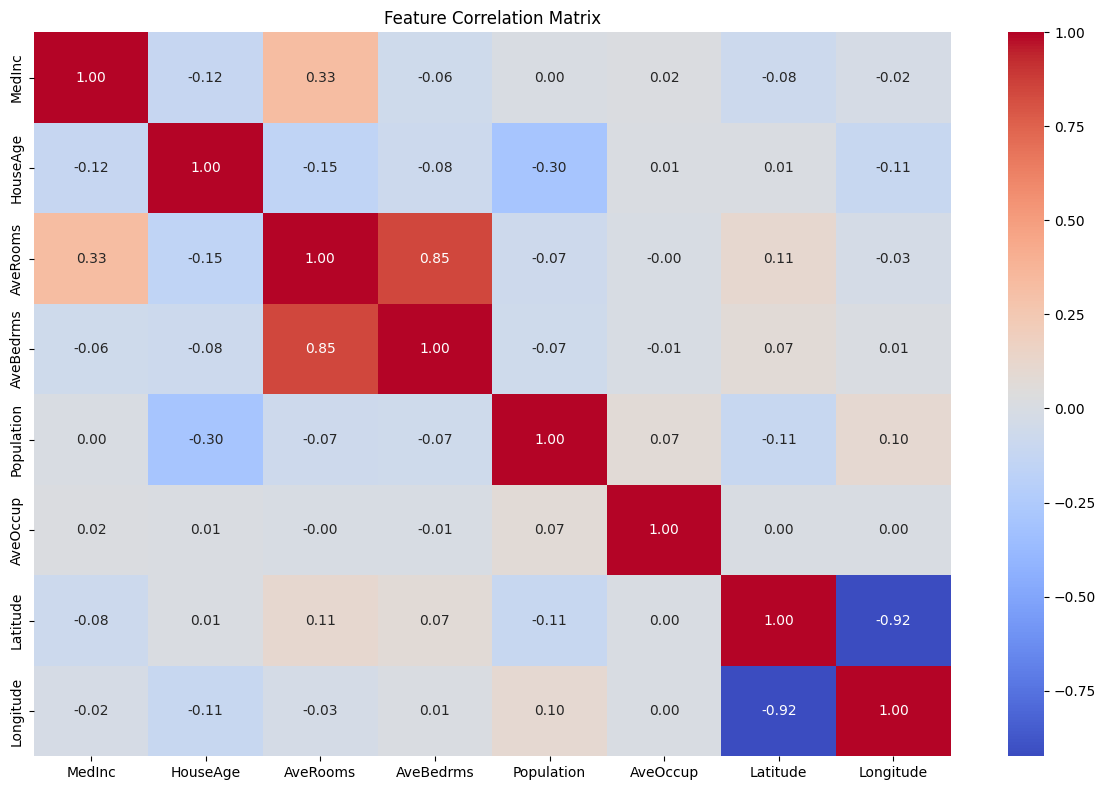

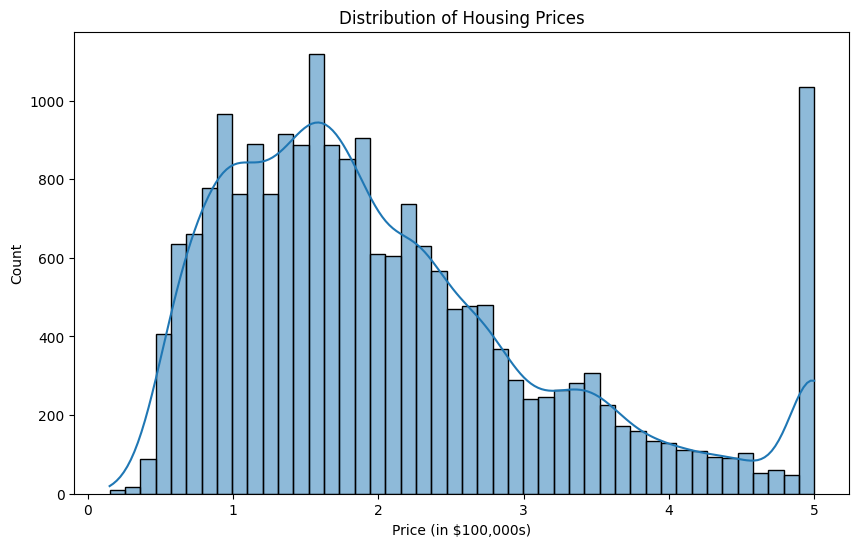

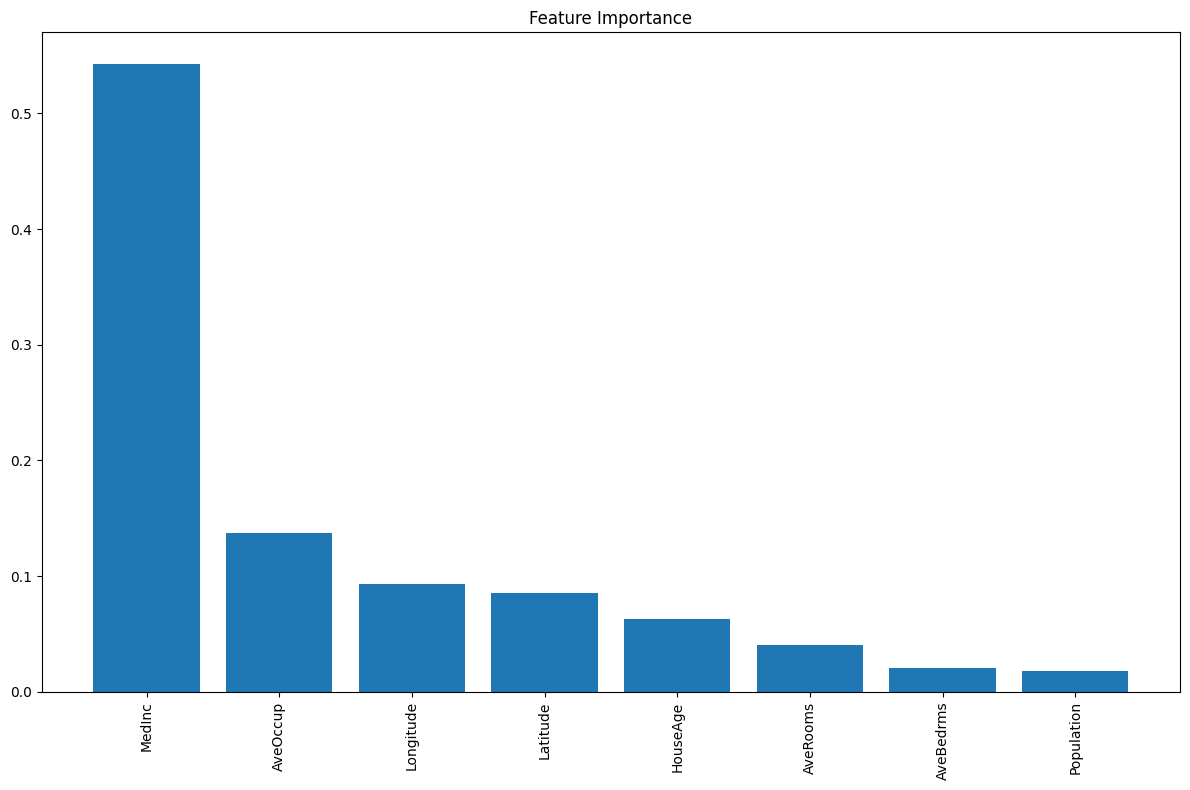

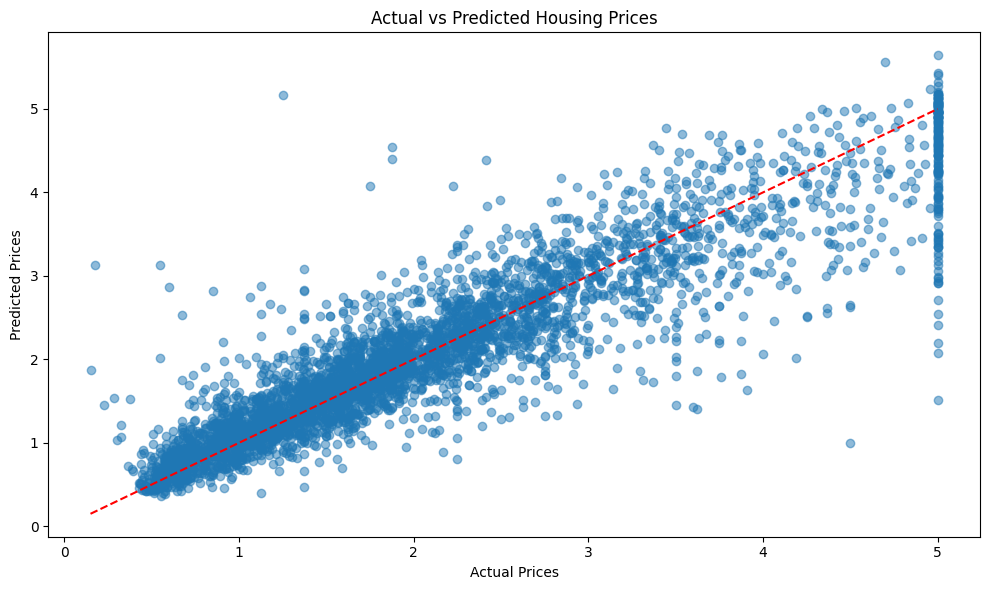

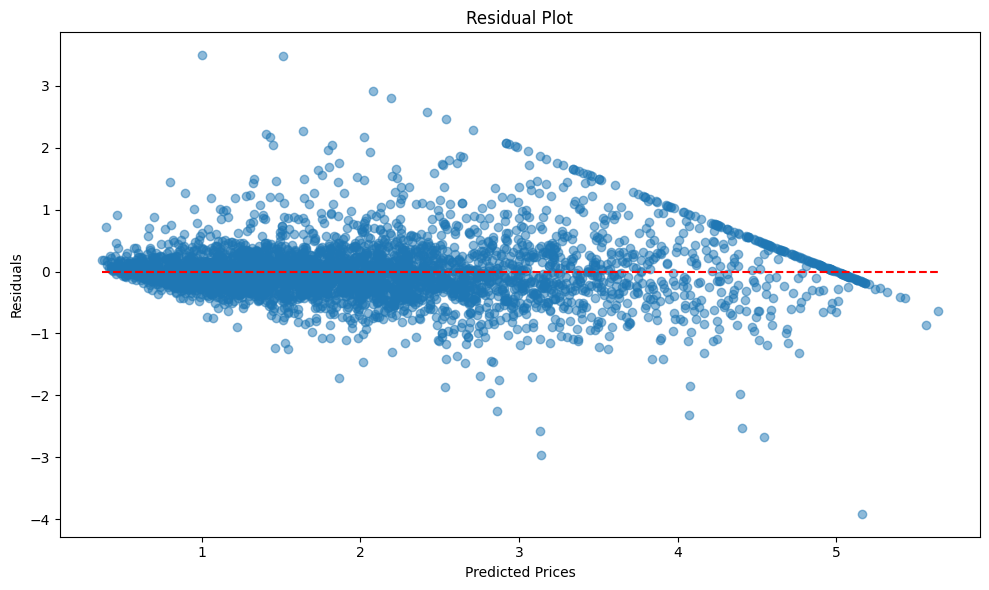

In [1]:
# California Housing Price Prediction Model

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the California housing dataset
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

print("Dataset loaded successfully.")
print(f"Dataset shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")

# Exploratory Data Analysis
print("\n--- Exploratory Data Analysis ---")
print(X.describe())

# Check for missing values
print("\nMissing values:")
print(X.isnull().sum())

# Data visualization
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

# Target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of Housing Prices')
plt.xlabel('Price (in $100,000s)')
plt.savefig('target_distribution.png')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), X.columns)
    ])

# Model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        'model': model.__class__.__name__,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'trained_model': model
    }

# Define and evaluate baseline models
models = [
    Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    Pipeline([('preprocessor', preprocessor), ('regressor', Ridge(alpha=1.0))]),
    Pipeline([('preprocessor', preprocessor), ('regressor', Lasso(alpha=0.1))]),
    Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]),
    Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))]),
    Pipeline([('preprocessor', preprocessor), ('regressor', XGBRegressor(n_estimators=100, random_state=42))])
]

# Evaluate each model
results = []
for model in models:
    result = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append(result)
    print(f"\n{result['model']} Performance:")
    print(f"MSE: {result['mse']:.4f}")
    print(f"RMSE: {result['rmse']:.4f}")
    print(f"MAE: {result['mae']:.4f}")
    print(f"R²: {result['r2']:.4f}")

# Create results dataframe
results_df = pd.DataFrame([{k: v for k, v in r.items() if k != 'trained_model'} for r in results])
print("\nModel Comparison:")
print(results_df)

# Find the best performing model
best_model_idx = results_df['r2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'model']
best_model = results[best_model_idx]['trained_model']
print(f"\nBest model: {best_model_name} with R² = {results_df.loc[best_model_idx, 'r2']:.4f}")

# Fine-tune the best model with GridSearchCV
print("\n--- Fine-tuning the best model ---")

if best_model_name == 'XGBRegressor':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
elif best_model_name == 'RandomForestRegressor':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'GradientBoostingRegressor':
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 5, 7]
    }
else:
    param_grid = {
        'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }

# Create GridSearchCV
grid_search = GridSearchCV(
    best_model,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model
final_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

# Evaluate the final model
y_pred = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print("\n--- Final Model Performance ---")
print(f"MSE: {final_mse:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"MAE: {final_mae:.4f}")
print(f"R²: {final_r2:.4f}")

# Feature importance (if applicable)
if hasattr(final_model.named_steps['regressor'], 'feature_importances_'):
    importance = final_model.named_steps['regressor'].feature_importances_
    feature_names = california.feature_names
    
    # Sort feature importances in descending order
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 8))
    plt.bar(range(X.shape[1]), importance[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    # Print feature importance
    print("\nFeature Importance:")
    for i in indices:
        print(f"{feature_names[i]}: {importance[i]:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Housing Prices')
plt.tight_layout()
plt.savefig('predictions_vs_actual.png')

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig('residual_plot.png')

# Cross-validation to ensure robustness
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)

print("\n--- Cross-Validation Results ---")
print(f"CV RMSE scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean():.4f}")
print(f"Standard deviation of CV RMSE: {cv_rmse.std():.4f}")

print("\n--- Final Model Summary ---")
print(f"Model: {best_model_name} with fine-tuned parameters")
print(f"Parameters: {best_params}")
print(f"Final R² on test set: {final_r2:.4f}")
print(f"Final RMSE on test set: {final_rmse:.4f}")

# Output model metrics in a table format
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'CV Mean RMSE'],
    'Value': [final_mse, final_rmse, final_mae, final_r2, cv_rmse.mean()]
})

print("\n--- Model Metrics Summary ---")
print(metrics_table)